# 定量的な評価方法（前処理2 & 最適化したパラメータ）

## 目的
カテゴリデータ（= 教師データ）を用いて定量的評価を行い、  
"evaluation_w_category_1-opt.ipynb"(前処理1 & 最適化パラメータのdoc_vec；**以下、モデル1**)の場合と比較する。

## モデル
doc2vec_pp1_setup2-default.model  
- "exp_params_setup2.ipynb"で、前処理2データをもちいてトレーニングしたDoc2Vecモデル（**以下、モデル2**)。
- defaultとなっているが、デフォルトパラメータが最適化パラメータなので最適化されたモデルのことである。

## 評価方法
"evaluation_w_category_1-opt.ipynb"(**モデル1**)と同じ。

## 結果
### 評価方法1
傾向はモデル1と同じ:  
"""dokujo-tsushin, movie-enter, smaxなどは、比較的よくラベル分けとカテゴリが一致している（70~80%）。   
一方で、kaden-cghannel, livedoor-hommeなどはあまり一致していない。"""   
似た傾向のあるカテゴリでは、切り分けが難しいということだろう。

この評価方法では、モデル2とモデル1との正解率の違いはあまりわからない。  
t-SNEのplotで見ると、モデル1の方がきれいにカテゴリ分けできていることがわかる。

### 評価方法2
#### 2-1. 正解率による評価
正解率（accuracy）は87%。  
モデル1の91%と比べて減少した。

#### 2-2. 9つのカテゴリ毎にも評価値を算出
評価2-1と同様に、モデル1に比べて評価値が下がっている。  
特定のカテゴリが上がったっリ・下がったりせず、全体的に下がっているように見える。

#### 2-3. 正しく予測した記事と、間違って予測した記事の比較
正解しているケースでは、「そのカテゴリらしい」記事内容を適切に予測できている。  

間違いのケースは、  
内容的には（間違った分類をしても）問題ないケースが多く見られた。

## 結論
前処理2のDoc2Vecモデル（を用いた教師あり学習）の精度は、前処理1よりも低かった。  
（acc1=91%, acc2=87%）

前処理1は、ほぼ生データを分かち書きしているだけなのに対して、前処理2は、データをcleaningする作業などを入れている。  
より多くの処理を入れた前処理2の方が良い結果になると期待していたが、そうではないことがわかった。  
**→定量的に評価することで、前処理２が不適切な処理(情報量を削除しすぎた？)である可能性が高いことが分かった。**  
このことから、  
**前処理を実装するとき、定量的に評価しながら適切な処理を入れていくことが大事**  
であることがわかった。

**注意点**  
今回の定量的評価が絶対的に正しいわけではないことを念頭に入れておくこと。  
Doc2Vecのfeatureから教師ありモデルの評価までに、不確定な要素はたくさんある。   
**Hyper parameter tuning**をするときに一元的な指標として用いるのは（ある程度）良いと思うが、  
今回のように**インプットデータを大幅に変更するケース**は、評価値だけで単純に比較してよいかは微妙なところ。  
t-SNEでプロットしたり予測した文章を見たり、**多角的に評価した方が良い**かもしれない。  

In [2]:
import sys
import os.path as osp
sys.path.append(osp.pardir)
import pickle
from utils import train_docs
from utils import evaluation_docs
from gensim.models.doc2vec import Doc2Vec

fn_model = './model/doc2vec_pp2_setup2-default.model'  # 2-defaultは、setup2で最適化されたパラメータ
fn_tagged_words_list = './preproc_data/words_list_mecab_pp2.pickle'
fn_category_map = './preproc_data/category_map_pp2.pickle'
n_clusters = 20
n_each_show = 5

model = Doc2Vec.load(fn_model)
tagged_words_list = pickle.load(open(fn_tagged_words_list, 'rb'))
dic_category_map = pickle.load(open(fn_category_map, 'rb'))

ed = evaluation_docs.evaluation_labeled_docs(model, tagged_words_list, n_clusters, dic_category_map)

## 1. Kmeansで学習したラベルとカテゴリの一致度


dokujo-tsushin 0.7488479262672811
it-life-hack 0.4793103448275862
kaden-channel 0.4550970873786408
livedoor-homme 0.3025540275049116
movie-enter 0.9124423963133641
peachy 0.6115107913669064
smax 0.6862068965517242
sports-watch 0.767337807606264
topic-news 0.9429708222811671


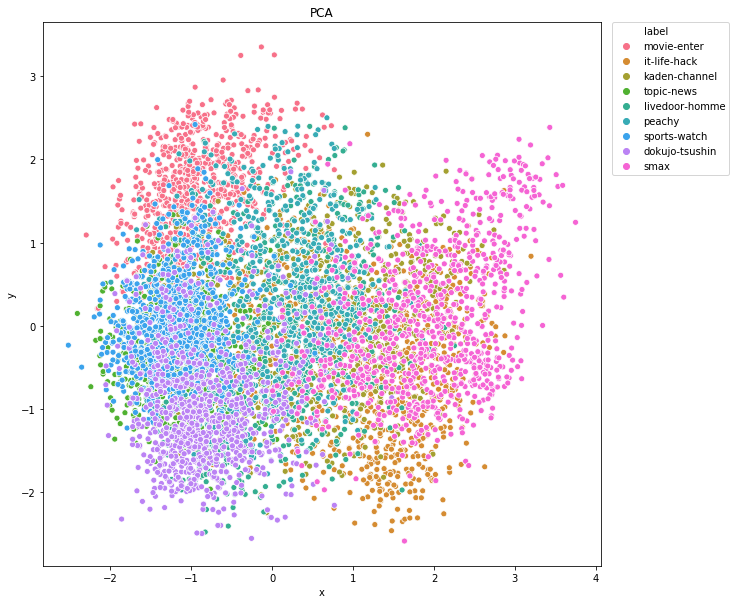

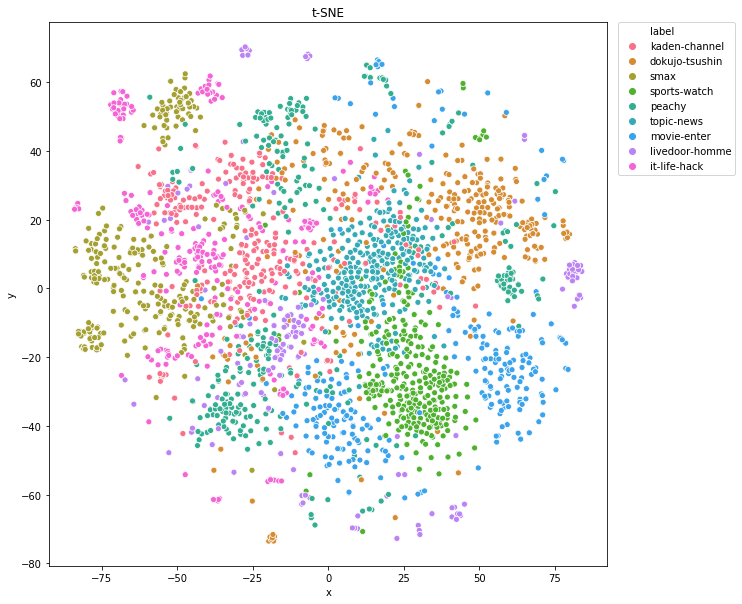

In [3]:
ed.eval_km_cat()
ed.plot2d('PCA', n_sample=None, label_kind='category')
ed.plot2d('t-SNE', n_sample=3000, label_kind='category')

## 2. 教師ありモデル（Neural net）を用いた評価



MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.4635477818145255
  Test accuracy: 0.8711446199701451
  Epoch: 152


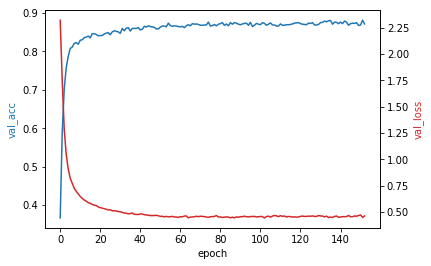


                 precision    recall  f1-score   support

dokujo-tsushin       0.87      0.87      0.87       173
  it-life-hack       0.87      0.86      0.86       174
 kaden-channel       0.81      0.81      0.81       165
livedoor-homme       0.77      0.76      0.77       102
   movie-enter       0.92      0.93      0.92       174
        peachy       0.84      0.80      0.82       167
          smax       0.90      0.94      0.92       174
  sports-watch       0.94      0.92      0.93       179
    topic-news       0.89      0.90      0.89       151

   avg / total       0.87      0.87      0.87      1459



In [4]:
mlp_model, score, history = ed.eval_sv(save_path=None, show_each_cat=True)

## 正解した記事と間違った記事の比較

### 正しく予測した記事
該当カテゴリ"らしい"記事が適切に予測されている。

### 間違って予測した記事
以下にいくつかの例をピックアップ。

**tag: t3890  
pred_cat: livedoor-homme  
real_cat: peachy**  
内容的に予測を外しているなと思えるのは、（10個の間違い記事のうち）この一つだけ。  
女性向けの内容なのに、男性生活系のカテゴリを予測している。

その他の記事はカテゴリ予測は間違っているが、内容的にはそこまで大外れではない  
ように見える。たとえば、  
**tag: t5589  
pred_cat: it-life-hack  
real_cat: dokujo-tsushin**  
だと、女性向けの記事という意味ではdokujoに入れるべき記事とも言えるが、  
スマホのスペックも記述されている内容を考えれば、予測されたIT系の記事に分類されても  
（内容的には）そこまでおかしくはない。


### 結論
正しい内容、間違っている内容を見る限り、

In [5]:
# 準備
from collections import defaultdict
pred_cats = mlp_model.predict_classes(ed.x_test)
y_test_int = [list(y).index(1) for y in ed.y_test]

dic_test_results = defaultdict(dict)
for pred_cat, real_cat, index in zip(pred_cats, y_test_int, ed.indices_test):
    tagged_words = tagged_words_list[index]
    words = tagged_words[0]
    tag = tagged_words.tags[0]
    dic_test_results[tag]['words'] = words
    dic_test_results[tag]['pred_cat'] = ed.le.inverse_transform(pred_cat)
    dic_test_results[tag]['real_cat'] = ed.le.inverse_transform(real_cat)
    dic_test_results[tag]['correct'] = pred_cat == real_cat

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

In [6]:
# 正解した記事と間違った記事を表示
n_show = 10
seed = 7

dic_correct = {k: v for k, v in dic_test_results.items() if v['correct']==1}
dic_wrong = {k: v for k, v in dic_test_results.items() if v['correct']==0}

random_wrong_tags = np.random.permutation(list(dic_wrong.keys()))

def print_results(dic, n_show, seed=0):
    np.random.seed(seed)
    random_tags = np.random.permutation(list(dic.keys()))
    for tag in random_tags[:n_show]:
        result = dic[tag]
        template = 'tag: {tag}\npred_cat: {pred_cat}\nreal_cat: {real_cat}\nwords:{words}'
        print(template.format(tag=tag, **result), end='\n\n')

#予測が正解した記事
print('\n=== Correct predictions ===')
print_results(dic_correct, n_show, seed)

#予測が間違った記事
print('\n=== Wrong predictions ===')
print_results(dic_wrong, n_show, seed)


=== Correct predictions ===
tag: t766
pred_cat: movie-enter
real_cat: movie-enter
words:['東京国際映画祭', '最強のふたり', 'グランプリ', '受賞', '小栗旬', 'キツツキと雨', '審査員', '特別賞', '00日', '本日', '0日間', '六本木ヒルズ', '中心', '開催', 'する', '第00回東京国際映画祭', 'tohoシネマズ六本木ヒルズ', 'スクリーン', '0', 'ジョン・カビラ', '久保純子', '司会', '下', 'クロージング', 'セレモニー', '行う', 'グランプリ', '作品', '発表', 'する', '賞', 'コンペティション', '部門', '審査', '委員長', '含む', '国際', '審査', '委員', '0', '選ぶ', '東京', 'サクラ', 'グランプリ', '一般', '観客', '対象', '投票', '募る', 'もっとも', '多く', '支持', '得る', '作品', '与える', '観客', 'アジア映画', '発展', '支援', 'する', '目的', '設ける', '最優秀', 'アジア映画', '様々', '賞', 'ある', '受賞作品', '次', '通り', 'コンペティション', '部門', '審査員', '特別賞', 'キツツキと雨', '最優秀監督賞', 'リューベン・オストルンド', 'play!', '最優秀', '女優賞', 'グレン・クローズ', 'アルバート・ノッブス', '最優秀', '男優賞', 'フランソワ・クリュゼ', 'オマール・シー', '共に', '最強のふたり', '最優秀', '芸術貢献賞', '転', 'デタッチメント', '観客', 'ガザ', '飛ぶ', 'ブタ', 'toyota', 'earth', 'grand', 'prix', '鏡', '嘘', 'つく', 'toyota', 'earth', 'grand', 'prix', '審査員', '特別賞', 'ハッピー・ピープル', 'タイガ', '暮らす', '一年', 'アジア', '風', '最優秀', 'アジア映画', 'クリスマス・イブ', '日本

## モデル1とモデル2の（間違って予測した記事の）比較

### 結果
モデル1とモデル2の両方で間違っているケースは、内容的には間違っても仕方がないケースがある。  
モデル１とモデル2のいずれかが間違っているケースについて、表示してみる限り、明らかな共通点は  
（パッと見では）なさげ。より詳細に調査する必要があるだろう。


MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.4894433943190911
  Test accuracy: 0.8677176146821015
  Epoch: 135


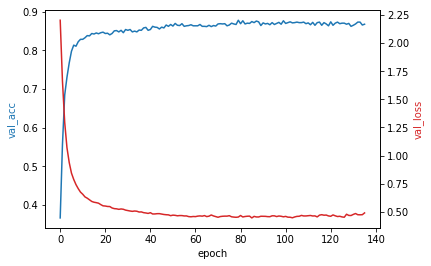


                 precision    recall  f1-score   support

dokujo-tsushin       0.87      0.85      0.86       173
  it-life-hack       0.90      0.84      0.87       174
 kaden-channel       0.79      0.79      0.79       165
livedoor-homme       0.81      0.77      0.79       102
   movie-enter       0.94      0.94      0.94       174
        peachy       0.80      0.80      0.80       167
          smax       0.86      0.94      0.90       174
  sports-watch       0.92      0.96      0.94       179
    topic-news       0.90      0.87      0.89       151

   avg / total       0.87      0.87      0.87      1459



/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

In [3]:
import sys
import os.path as osp
sys.path.append(osp.pardir)
import pickle
from utils import train_docs
from utils import evaluation_docs
from gensim.models.doc2vec import Doc2Vec

fn_model2 = './model/doc2vec_pp2_setup2-default.model'  # 2-defaultは、setup2で最適化されたパラメータ
fn_tagged_words_list2 = './preproc_data/words_list_mecab_pp2.pickle'
fn_category_map2 = './preproc_data/category_map_pp2.pickle'
n_clusters = 20
n_each_show = 5

model2 = Doc2Vec.load(fn_model2)
tagged_words_list2 = pickle.load(open(fn_tagged_words_list2, 'rb'))
dic_category_map2 = pickle.load(open(fn_category_map2, 'rb'))

ed2 = evaluation_docs.evaluation_labeled_docs(model2, tagged_words_list2, n_clusters, dic_category_map2)
mlp_model2, score2, history2 = ed2.eval_sv(save_path=None, show_each_cat=True)
dic_results2 = ed2.make_correct_pred_dict()


MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3901654033729522
  Test accuracy: 0.9013022619048727
  Epoch: 154


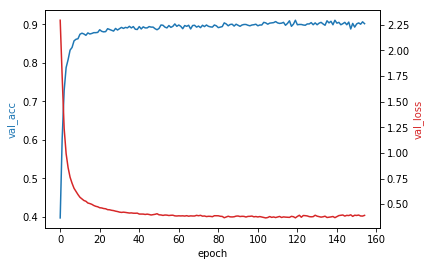


                 precision    recall  f1-score   support

dokujo-tsushin       0.93      0.88      0.90       173
  it-life-hack       0.87      0.92      0.89       174
 kaden-channel       0.85      0.83      0.84       165
livedoor-homme       0.78      0.75      0.76       102
   movie-enter       0.98      0.95      0.97       174
        peachy       0.86      0.89      0.87       167
          smax       0.94      0.96      0.95       174
  sports-watch       0.96      0.93      0.95       179
    topic-news       0.89      0.94      0.91       151

   avg / total       0.90      0.90      0.90      1459



/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/usr010229

In [5]:
fn_model1 = './model/doc2vec_pp1_setup1-opt.model'
fn_tagged_words_list1 = './preproc_data/words_list_mecab_pp1.pickle'
fn_category_map1 = './preproc_data/category_map_pp1.pickle'
n_clusters = 20
n_each_show = 5

model1 = Doc2Vec.load(fn_model1)
tagged_words_list1 = pickle.load(open(fn_tagged_words_list1, 'rb'))
dic_category_map1 = pickle.load(open(fn_category_map1, 'rb'))

ed1 = evaluation_docs.evaluation_labeled_docs(model1, tagged_words_list1, n_clusters, dic_category_map1)
mlp_model1, score1, history1 = ed1.eval_sv(save_path=None, show_each_cat=True)
dic_results1 = ed1.make_correct_pred_dict()

In [21]:
from collections import defaultdict

dic_compare = defaultdict(dict)
for tag, dic_v2 in dic_results2.items():
        dic_v1 = dic_results1.get(tag, None)
        if dic_v1 is None:
            continue
            
        if dic_v1['correct'] and dic_v2['correct']:
            dic_compare['cor1_cor2'][tag] = {}
            dic_compare['cor1_cor2'][tag]['pp1'] = dic_v1
            dic_compare['cor1_cor2'][tag]['pp2'] = dic_v2
        elif not dic_v1['correct'] and dic_v2['correct']:
            dic_compare['wrg1_cor2'][tag] = {}
            dic_compare['wrg1_cor2'][tag]['pp1'] = dic_v1
            dic_compare['wrg1_cor2'][tag]['pp2'] = dic_v2
        elif dic_v1['correct'] and not dic_v2['correct']:
            dic_compare['cor1_wrg2'][tag] = {}
            dic_compare['cor1_wrg2'][tag]['pp1'] = dic_v1
            dic_compare['cor1_wrg2'][tag]['pp2'] = dic_v2
        elif not dic_v1['correct'] and not dic_v2['correct']:
            dic_compare['wrg1_wrg2'][tag] = {}
            dic_compare['wrg1_wrg2'][tag]['pp1'] = dic_v1
            dic_compare['wrg1_wrg2'][tag]['pp2'] = dic_v2


In [22]:
for k, v in dic_compare.items():
    print(k, len(v))

cor1_cor2 1212
cor1_wrg2 103
wrg1_wrg2 90
wrg1_cor2 54


In [45]:
def show_compare(key, n_show=5):
    print('o' * 20)
    print('ooooo %s ooooo' % key)
    print('o' * 20)
    for i, (tag, dic_v) in enumerate(dic_compare[key].items()):
        print('===== %s =====' % tag)
        for pp, dic_pp in dic_v.items():
            print('--- %s ---' % pp)
            for k, dic_each in dic_pp.items():
                print(k, dic_each)
        print('\n')
        if i >= (n_show-1):
            break

# 両方とも間違って予測している場合
show_compare('wrg1_wrg2')
# モデル1では正しく予測して、モデル2では間違って予測した場合
show_compare('cor1_wrg2')
# モデル1では間違って予測して、モデル2では正しく予測した場合
show_compare('wrg1_cor2')

oooooooooooooooooooo
ooooo wrg1_wrg2 ooooo
oooooooooooooooooooo
===== t4601 =====
--- pp1 ---
words ['【', 'iPhone', '版', '】', '新しく', 'なっ', 'た', '♪', 'Peachy', 'アプリ', 'の', '使い方', 'リニューアル', 'し', 'た', 'Peachy', 'iPhoneアプリ', 'の', '、', '便利', 'な', '機能', 'を', 'ご', '紹介', 'し', 'ます', '！', 'メニュー', 'ボタン', 'が', '増え', 'まし', 'た', '！', '左上', 'の', 'ボタン', 'を', 'タップ', '！', 'TOP', 'ページ', 'より', '画面', '左上', 'の', '【', 'メニュー', 'ボタン', '】', 'を', 'タップ', 'する', 'と', '、', 'Peachy', 'の', 'カテゴリー', '一覧', 'へ', '。', '今', '自分', 'が', '一番', '見', 'たい', 'カテゴリ', 'へ', 'すぐ', 'アクセス', 'できる', 'よう', 'に', 'なり', 'まし', 'た', '。', '記事', 'を', 'お気に入り', 'に', '登録', '＆', '記事', 'を', 'シェア', 'しよう', '！', 'タイトル', 'を', '見', 'て', '「', 'これ', 'は', '後で', 'チェック', 'し', 'たい', '！', '」', 'と', '思っ', 'たら', '★', '型', 'の', 'ボタン', 'を', 'タップ', '！', 'あなた', 'の', '【', 'お気に入り', 'フォルダ', '】', 'に', 'チェック', 'し', 'た', '記事', 'が', '保存', 'さ', 'れ', 'ます', '。', '時間', 'の', 'ある時', 'に', '、', 'まとめ', 'て', '【', 'お気に入り', 'フォルダ', '】', 'から', 'ゆっくり', '読む', 'こと', 'が', 'でき', 'ます', '。', '※